In [35]:
dropbox_path='/home/boareto/Dropbox/'
#dropbox_path='/Users/marcelob/Dropbox/'

import sys
import itertools
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from scipy import special
from scipy.stats.stats import pearsonr 
from scipy.stats import ttest_ind
from sklearn import manifold
from sklearn.decomposition import PCA

cmap = plt.cm.get_cmap('Blues')
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style('white')
sns.set_context('notebook', font_scale=1.7, rc={'lines.linewidth': 1.3})

# calculate fold change
def FC(X, y, absolute=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    fc = np.mean(X[:,y==0], axis=1) - np.mean(X[:,y==1], axis=1)
    if absolute:
        return np.abs(fc)
    return fc

def ttest(X, y, p_value=True, equal_var=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    t, p = ttest_ind(X.T[y==0], X.T[y==1], equal_var=equal_var)
    p[np.isnan(p)] = 1.0
    t[np.isnan(t)] = 0.0
    return t,p

def sum_var(X, y):
    return np.var(X[:,y==0], axis=1) + np.var(X[:,y==1], axis=1)

def suvrel(X, y, gamma=None, p=None, print_gamma=False):
    if set(y) != {0,1}:
        print 'Only two classes accepted: y=0 and y=1'
        return 0
    
    if len(y) != np.shape(X)[1]:
        print 'check the length of y'
        return 0
    
    if gamma==None:
        if p==None:
            print 'Define either gamma or a minimum p-value'
            return 0
        else:
            t = tvalue_from_pvalue(p)
            gamma = 1.0/(t**2 + 2.0)
    elif gamma>0.5:
        print 'gamma>0.5, are you sure?'
        
    w = gamma*FC(X, y)**2 - (1.0 - 2.0*gamma)*sum_var(X,y)
    w[w<0] = 0.0
    
    if print_gamma:
        print 'Suvrel analysis: gamma = ',gamma
    return [w/np.sqrt(np.sum(w**2)), 2*w]

def calculate_tvalue(X, y):
    return FC(X,y)/np.sqrt(np.var(X[:,y==0], axis=1) + np.var(X[:,y==1], axis=1))  

def tvalue_from_pvalue(p):
    return 2.0*special.erfcinv(p)

def pvalue_from_tvalue(t):
    return special.erfc(t/2.0)

def pcorr(x,y, log_scale=False):
    if log_scale:
        x = np.log2(x)
        y = np.log2(y)
    [corr,p] = pearsonr(x, y)
    a,b   = np.polyfit(x, y, 1) 
    return [corr, p, a, b]

def dimensional_reduction(D, pc=[0,1], c='g', clabel=None, cbar=True, clim=None, xticks=[], yticks=[], cticks=None,
                          x_fit=None, cmap='Blues', fs=[9,5], ms=200, marker=None, label=None, ax=None, 
                          return_fit=False, xlim=None, ylim=None):
    if ax==None:
        f = plt.subplots(1, 1, figsize=(fs[0], fs[1]), sharex=True, sharey=True)
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1, rowspan=1)
    if x_fit==None:
        x_fit = PCA(n_components=3).fit(D.T)
    x = x_fit.transform(D.T)

    im = plt.scatter(x[:,pc[0]], x[:,pc[1]], c=c, cmap=cmap, marker='o', s=ms, alpha=0.9)
    if label!=None:
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.8))
    if cbar:
        cbar = plt.colorbar(im, orientation='vertical')
        if cticks!=None:
            cbar.ax.set_yticks(set(c))
            cbar.ax.set_yticklabels(cticks)
        if clabel!=None:
            if clim!=None:
                plt.clim([clim[0], clim[1]])
            else:
                plt.clim([np.min(c), np.max(c)])
            cbar.set_label(clabel)
    if xlim!=None:
        plt.xlim(xlim)
    if ylim!=None:
        plt.ylim(ylim)
    if xticks!=None:
        plt.xticks(xticks)
    if yticks!=None:
        plt.yticks(yticks)
    ax.autoscale_view()
    if return_fit:
        return x_fit
    
def id_to_ensembl(g_name):
    return [list(D['iGene_bk'][D['iGene_bk']['gene_short_name']==g]['GeneID']) for g in g_name]

def ensembl_to_id(g_name):
    return [D['iGene_bk'].loc[g]['gene_short_name'] for g in g_name]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# ------------ Data processed by Zahra K. -----------------------

path_data = dropbox_path+'/data/systemX_bulk_BWT_Z/'
pD = pd.read_csv(path_data+'pData.txt', header=0, index_col=0, sep='\t')
# getting the list of NSCs bulk data that are good. (check this with Zahra)
list_nsc = pD[pD['Cell_Type']=='Hes5::GFP']['Sample_ID']


path_data = dropbox_path+'/data/SystemX_2017_08_23_ZK/'
D = {}
D['bk']         = pd.read_csv(path_data+'EXPression_Bulk_all.txt', header=0, index_col=0, sep='\t') 
D['iGene_bk'  ] = pd.read_csv(path_data+'fData_Bulk_all.txt',      header=0, index_col=0, sep='\t')
D['iSample_bk'] = pd.read_csv(path_data+'pData_Bulk_all.txt',      header=0, index_col=0, sep='\t')

gene_length = D['iGene_bk']['End']-D['iGene_bk']['Start']

D['bk'] = D['bk'].loc[gene_length.index]

# ----------- reads per million (RPM) -----------------------
D['bk_rpm'] = (D['bk']/D['bk'].sum())*10**6
D['bk_rpm'] = np.log2(D['bk_rpm'] + 1.0)


# ------- trancripts per kilobase per million (TPM) ---------
D['bk_tpm'] = D['bk'].loc[gene_length.index]
rpk = D['bk'].values/pd.to_numeric(gene_length).astype(float)[:,None]
tpm = (rpk/np.sum(rpk, axis=0))*1e+6
D['bk_tpm'].values[:,:] = tpm
D['bk_tpm'] = np.log2(D['bk_tpm'] + 1.0)

864 >1e+6 reads, 1024 >0.5e+6 reads
Number of cells below the threshold of 500000.0 reads =  30
Total number of accepted cells =  1024


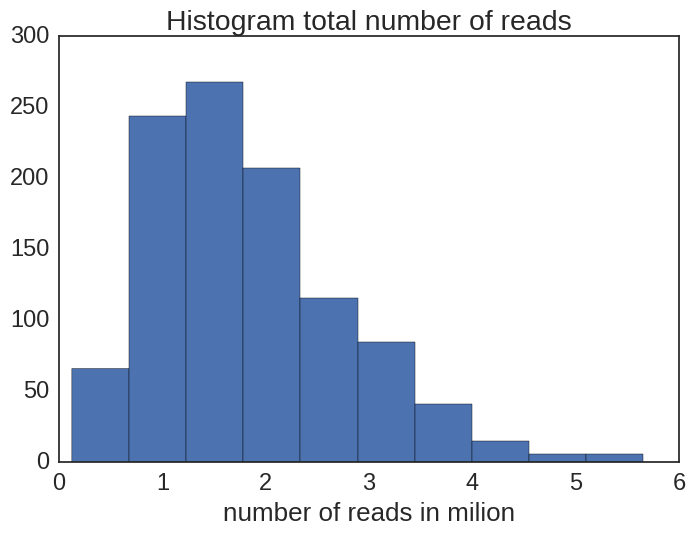

In [38]:
D['sc']         = pd.read_csv(path_data+'EXPression_SC_all.txt', header=0, index_col=0, sep='\t') 
D['iGene_sc'  ] = pd.read_csv(path_data+'fData_SC_all.txt',      header=0, index_col=0, sep='\t')
D['iSample_sc'] = pd.read_csv(path_data+'pData_SC_all.txt',      header=0, index_col=0, sep='\t')

D['min_reads'] = 0.5e+6

n_reads = np.sum(D['sc'].values, axis=0)
plt.hist(n_reads/1.0e+6, bins=10)
plt.xlabel('number of reads in milion')
plt.title('Histogram total number of reads')

# removing cells with low reads counts. 
D['sc']  = D['sc'].T[ n_reads>=D['min_reads']].T
D['iSample_sc'] = D['iSample_sc'][n_reads>=D['min_reads']]
print sum(n_reads>1e+6), '>1e+6 reads,', sum(n_reads>0.5e+6), '>0.5e+6 reads'
print 'Number of cells below the threshold of', D['min_reads'], 'reads = ', np.sum(n_reads < D['min_reads'])
print 'Total number of accepted cells = ', len(D['sc'].columns)

D['sc'] = D['sc'].loc[gene_length.index]
# ----------- reads per million -----------------------
D['sc_rpm'] = (D['sc']/D['sc'].sum())*10**6
D['sc_rpm'] = np.log2(D['sc_rpm'] + 1.0)

# ------- trancripts per kilobase per million (TPM) ---------
D['sc_tpm'] = D['sc'].loc[gene_length.index]
rpk = D['sc'].values/pd.to_numeric(gene_length).astype(float)[:,None]
tpm = (rpk/np.sum(rpk, axis=0))*1e+6
D['sc_tpm'].values[:,:] = tpm
D['sc_tpm'] = np.log2(D['sc_tpm'] + 1.0)

RPM. Variance explained= [ 0.42188258  0.2722862   0.06531132]


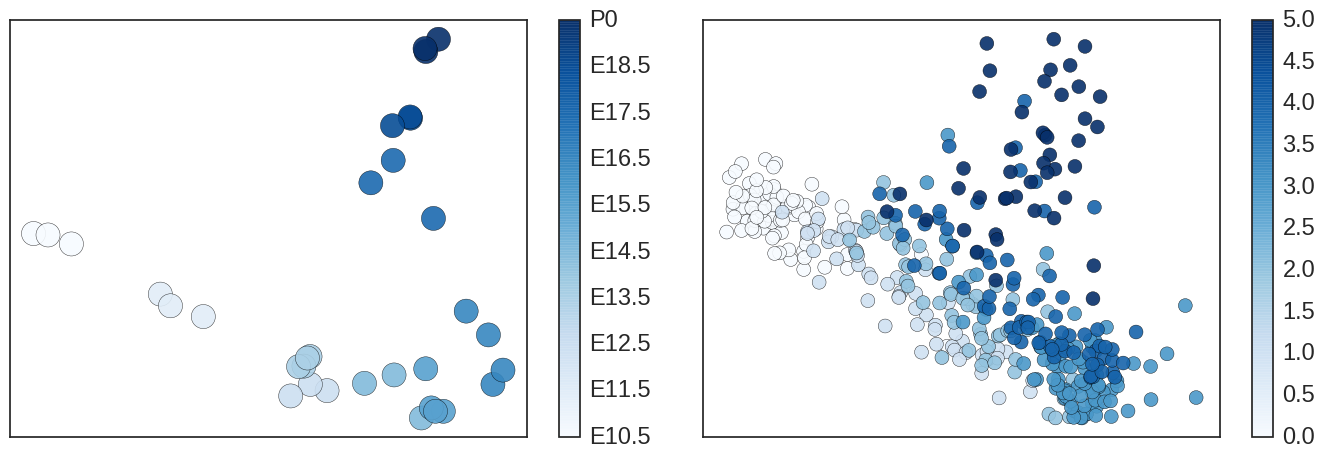

TPM. Variance explained= [ 0.24477083  0.1420892   0.08249852]


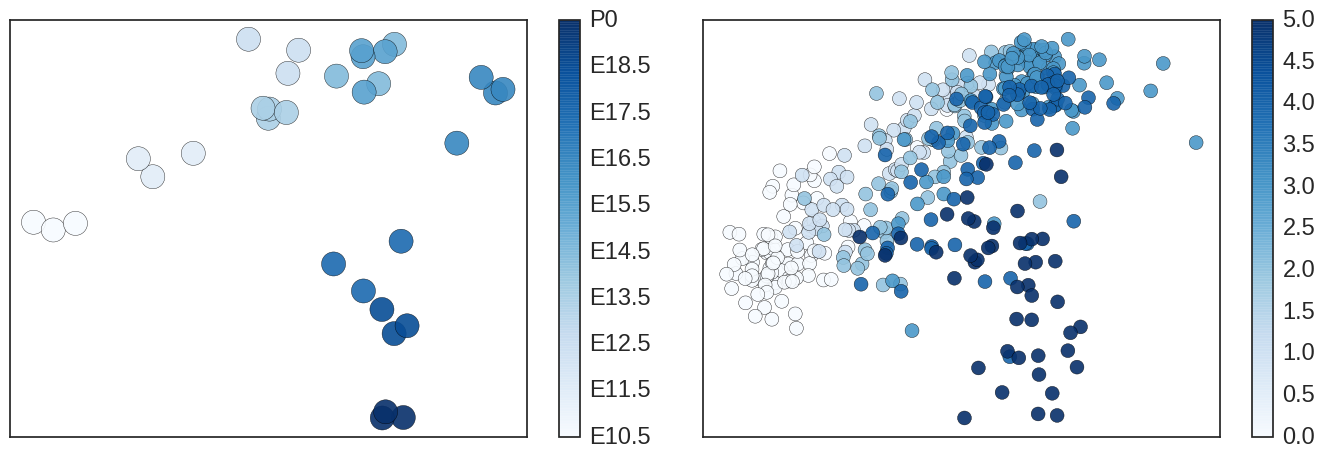

In [39]:
# ---------  PCA representation of the data -----------------------------

t_points_bk = ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','E17.5','E18.5','P0']
t_points_sc = ['E10.5','E11.5','E13.5','E15.5','E17.5','P0']


f = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
D['bkNSC_rpm'] = D['bk_rpm'][list_nsc.str.replace('-', '.')]
ynsc = np.zeros(D['bkNSC_rpm'].shape[1])

for i in range(len(t_points_bk)):
    ynsc += i*1.0*(D['iSample_bk'].loc[list_nsc]['Time'] == t_points_bk[i]).values
    
x_fit = dimensional_reduction(D['bkNSC_rpm'], c=ynsc, return_fit=True, ax=ax, ms=300, cticks=t_points_bk)
print 'RPM. Variance explained=',x_fit.explained_variance_ratio_

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
samples_sc = []
ynsc_sc = []
for i in range(len(t_points_sc)):
    query = '(Condition == "WT") & (Cell_Type=="Hes5::GFP") & (Time=="'+t_points_sc[i]+'")'
    samples_sc += list(D['iSample_sc'].query(query)['Sample_ID'].str.replace('-', '.'))
    ynsc_sc += list(i*np.ones(len(D['iSample_sc'].query(query)['Sample_ID'])))

D['scNSC_rpm'] = D['sc_rpm'][samples_sc]
dimensional_reduction(D['scNSC_rpm'], c=ynsc_sc, x_fit=x_fit, ax=ax, ms=100)
plt.show()



f = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
D['bkNSC_tpm'] = D['bk_tpm'][list_nsc.str.replace('-', '.')]
ynsc = np.zeros(D['bkNSC_tpm'].shape[1])

for i in range(len(t_points_bk)):
    ynsc += i*1.0*(D['iSample_bk'].loc[list_nsc]['Time'] == t_points_bk[i]).values
    
x_fit = dimensional_reduction(D['bkNSC_tpm'], c=ynsc, return_fit=True, ax=ax, ms=300, cticks=t_points_bk)
print 'TPM. Variance explained=',x_fit.explained_variance_ratio_

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
samples_sc = []
ynsc_sc = []
for i in range(len(t_points_sc)):
    query = '(Condition == "WT") & (Cell_Type=="Hes5::GFP") & (Time=="'+t_points_sc[i]+'")'
    samples_sc += list(D['iSample_sc'].query(query)['Sample_ID'].str.replace('-', '.'))
    ynsc_sc += list(i*np.ones(len(D['iSample_sc'].query(query)['Sample_ID'])))

D['scNSC_tpm'] = D['sc_tpm'][samples_sc]
dimensional_reduction(D['scNSC_tpm'], c=ynsc_sc, x_fit=x_fit, ax=ax, ms=100)

3379


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


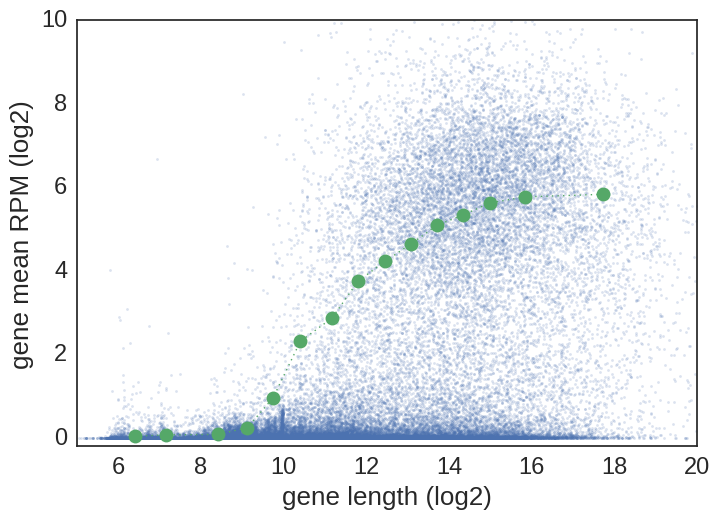

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:33: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


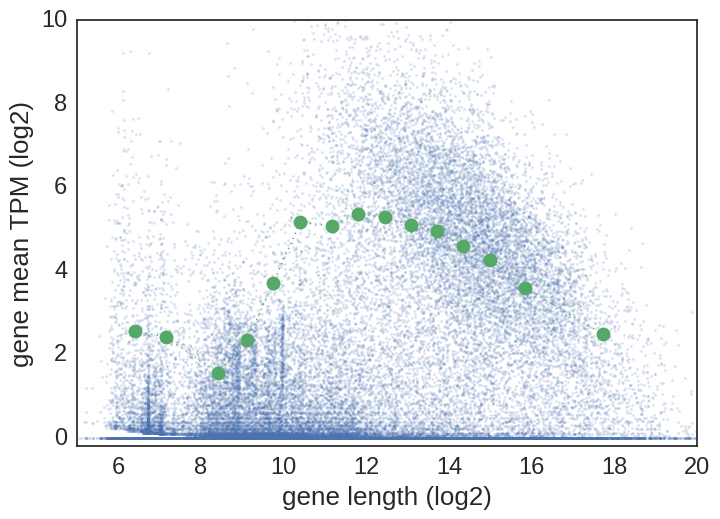

In [40]:
# Checking the relation between gene expression and gene length

pD_l_mean = pd.concat([D['iGene_bk']['End']-D['iGene_bk']['Start'],
                       (2**D['bkNSC_rpm'].loc[D['iGene_bk'].index]-1.0).mean(axis=1)], axis=1, keys=['length','mean'])

pD_l_mean = pD_l_mean.sort('length')


plt.plot(np.log2(pD_l_mean['length']), np.log2(pD_l_mean['mean']+1.0), 'o', ms=2, alpha=0.2)

n_points = 15
dl = int(D['bkNSC_rpm'].shape[0]/np.float(n_points))
print dl

length = []
mean = []
for i in range(n_points):
    length += [ pD_l_mean['length'][dl*i:dl*(i+1)].mean()]    
    mean   += [ pD_l_mean['mean'][  dl*i:dl*(i+1)].mean()+1.0]
    
plt.plot(np.log2(length), np.log2(mean), 'o:', lw=1, ms=10)
plt.xlim([5,20])
plt.ylim([-.2, 10])
plt.xlabel('gene length (log2)')
plt.ylabel('gene mean RPM (log2)')
plt.show()


# Checking the relation between gene expression and gene length
pD_l_mean = pd.concat([D['iGene_bk']['End']-D['iGene_bk']['Start'],
                       (2**D['bkNSC_tpm'].loc[D['iGene_bk'].index]-1.0).mean(axis=1)], axis=1, keys=['length','mean'])

pD_l_mean = pD_l_mean.sort('length')


plt.plot(np.log2(pD_l_mean['length']), np.log2(pD_l_mean['mean']+1.0), 'o', ms=2, alpha=0.2)

length = []
mean = []
for i in range(n_points):
    length += [ pD_l_mean['length'][dl*i:dl*(i+1)].mean()]    
    mean   += [ pD_l_mean['mean'][  dl*i:dl*(i+1)].mean()+1.0]
    
plt.plot(np.log2(length), np.log2(mean), 'o:', lw=1, ms=10)
plt.xlim([5,20])
plt.ylim([-.2, 10])
plt.xlabel('gene length (log2)')
plt.ylabel('gene mean TPM (log2)')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


[1.8296747526620241,
 1.8135003863561097,
 1.6602074585113449,
 1.8017938750153313,
 1.9234371867301283,
 1.9721692958999335,
 1.9702619768703376,
 1.9758446791226643,
 1.9742469317087672,
 1.9708156220580264,
 1.9674644049379808,
 1.9582891001110974,
 1.9477182929007772,
 1.9173573503242873,
 1.8205257380516273]

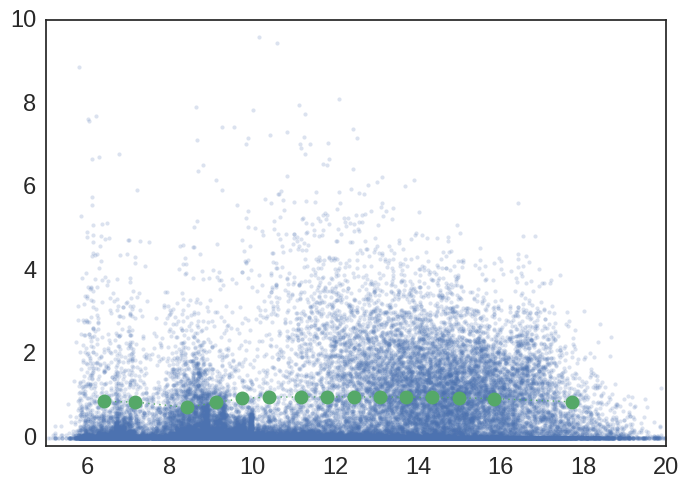

In [41]:
# Correcting the bias towards gene length

D['bkNSC_Ctpm'] = D['bkNSC_tpm'].copy() 

for i in range(n_points):
    D['bkNSC_Ctpm'].loc[pD_l_mean.index[dl*i:dl*(i+1)]] = (2**D['bkNSC_tpm'].loc[pD_l_mean.index[dl*i:dl*(i+1)]]-1.0)/mean[i]
    if i==(n_points-1):
        D['bkNSC_Ctpm'].loc[pD_l_mean.index[dl*i:]] = (2**D['bkNSC_tpm'].loc[pD_l_mean.index[dl*i:]]-1.0)/mean[i]
    
D['bkNSC_Ctpm'] = np.log2(D['bkNSC_Ctpm']+1.0)


# checking correction
pD_l_mean = pd.concat([D['iGene_bk']['End']-D['iGene_bk']['Start'],
                       (2**D['bkNSC_Ctpm'].loc[D['iGene_bk'].index]-1.0).mean(axis=1)], axis=1, keys=['length','mean'])

# Correcting the bias towards gene length

# D['bkNSC_Crpm'] = D['bkNSC_rpm'].copy() 

# for i in range(n_points):
#     D['bkNSC_Crpm'].loc[pD_l_mean.index[dl*i:dl*(i+1)]] = (2**D['bkNSC_rpm'].loc[pD_l_mean.index[dl*i:dl*(i+1)]]-1.0)/(mean[i]-1.0)
#     if i==(n_points-1):
#         D['bkNSC_Crpm'].loc[pD_l_mean.index[dl*i:]] = (2**D['bkNSC_rpm'].loc[pD_l_mean.index[dl*i:]]-1.0)/(mean[i]-1.0)
    
# D['bkNSC_Crpm'] = np.log2(D['bkNSC_Crpm']+1.0)


# # checking correction
# pD_l_mean = pd.concat([D['iGene_bk']['End']-D['iGene_bk']['Start'],
#                        (2**D['bkNSC_Crpm'].loc[D['iGene_bk'].index]-1.0).mean(axis=1)], axis=1, keys=['length','mean'])


pD_l_mean = pD_l_mean.sort('length')


plt.plot(np.log2(pD_l_mean['length']), np.log2(pD_l_mean['mean']+1.0), 'o', ms=3, alpha=0.2)

length = []
mean = []
for i in range(n_points):
    length += [pD_l_mean['length'][dl*i:dl*(i+1)].mean()]    
    mean   += [pD_l_mean['mean'][  dl*i:dl*(i+1)].mean()+1.0]
    
plt.plot(np.log2(length), np.log2(mean), 'o:', lw=1, ms=10)
plt.xlim([5,20])
plt.ylim([-.2, 10])
mean

[ 0.26392037  0.14582521  0.07937899]


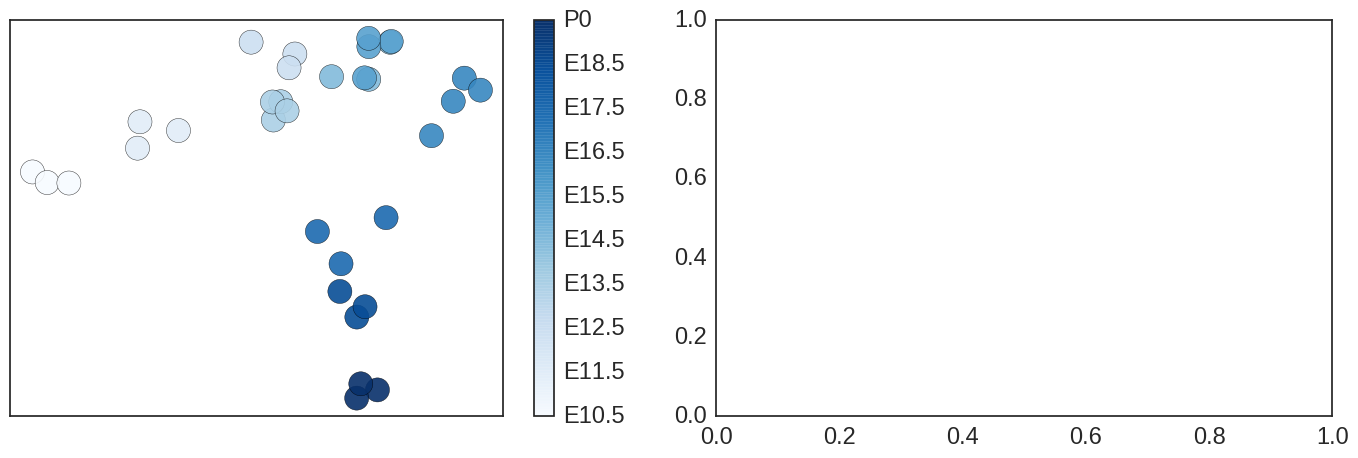

In [42]:
f = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)

# D['bkNSC_Crpm'] = D['bkNSC_Crpm'][list_nsc.str.replace('-', '.')]
# ynsc = np.zeros(D['bkNSC_Crpm'].shape[1])
D['bkNSC_Ctpm'] = D['bkNSC_Ctpm'][list_nsc.str.replace('-', '.')]
ynsc = np.zeros(D['bkNSC_Ctpm'].shape[1])

for i in range(len(t_points_bk)):
    ynsc += i*1.0*(D['iSample_bk'].loc[list_nsc]['Time'] == t_points_bk[i]).values
    
# x_fit = dimensional_reduction(D['bkNSC_Crpm'], c=ynsc, return_fit=True, ax=ax, ms=300, cticks=t_points_bk)
x_fit = dimensional_reduction(D['bkNSC_Ctpm'], c=ynsc, return_fit=True, ax=ax, ms=300, cticks=t_points_bk)
print x_fit.explained_variance_ratio_

# ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)

# samples_sc = []
# ynsc_sc = []
# for i in range(len(time_points_sc)):
#     query = '(Condition == "WT") & (Cell_Type=="Hes5::GFP") & (Time=="'+time_points_sc[i]+'")'
#     samples_sc += list(D['iSample_sc'].query(query)['Sample_ID'].str.replace('-', '.'))
#     ynsc_sc += list(i*np.ones(len(D['iSample_sc'].query(query)['Sample_ID'])))

# Xnsc_sc = D['sc'][samples_sc]
# dimensional_reduction(Xnsc_sc, c=ynsc_sc, x_fit=x_fit, ax=ax, ms=100)
# #print x_fit.explained_variance_ratio_


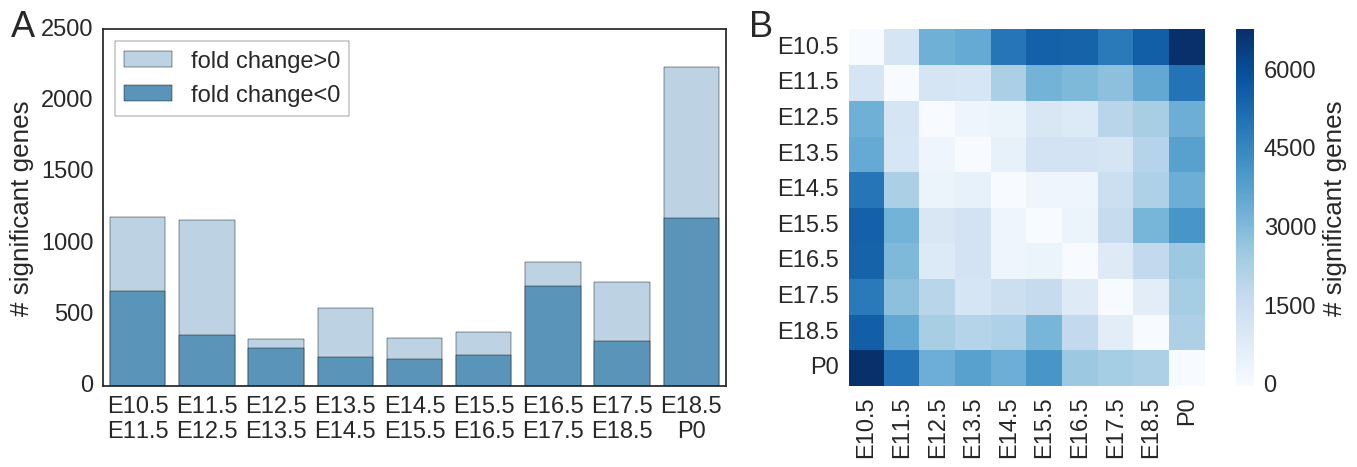

In [43]:
ncl = len(t_points_bk)
n,m = D['bkNSC_Ctpm'].shape
min_pvalue = 1.0e-6

n_sig     = np.zeros((ncl,ncl))
n_sig_neg = np.zeros((ncl,ncl))
for i in itertools.combinations(range(ncl),2):
    X = np.concatenate((D['bkNSC_Ctpm'].values[:,(ynsc==i[0])], D['bkNSC_Ctpm'].values[:,(ynsc==i[1])]), axis=1)
    y = np.concatenate((np.zeros(np.sum(ynsc==i[0])), np.ones(np.sum(ynsc==i[1]))))
    t = calculate_tvalue(X, y)
    p = special.erfc(np.abs(t)/np.sqrt(2.0))
    n_sig[i[0],i[1]] = np.sum(p<min_pvalue)
    n_sig[i[1],i[0]] = np.sum(p<min_pvalue)
    n_sig_neg[i[0],i[1]] = np.sum((p<min_pvalue) & (t<0))
    n_sig_neg[i[1],i[0]] = np.sum((p<min_pvalue) & (t<0))

n_sig     = pd.DataFrame(n_sig,     index=np.array(t_points_bk), columns=np.array(t_points_bk))
n_sig_neg = pd.DataFrame(n_sig_neg, index=np.array(t_points_bk), columns=np.array(t_points_bk))

f = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
sns.barplot([t_points_bk[i]+'\n'+t_points_bk[i+1] for i in range(ncl-1)],
            [n_sig.values[i,i+1] for i in range(ncl-1)], color=cmap(0.3), label='fold change>0', ax=ax)
sns.barplot([t_points_bk[i]+'\n'+t_points_bk[i+1] for i in range(ncl-1)],
            [n_sig_neg.values[i,i+1] for i in range(ncl-1)], color=cmap(0.6), label='fold change<0', ax=ax)
plt.ylabel('# significant genes')
ax.legend(ncol=1, loc='upper left', frameon=True)

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
ax.text(-23.5, 9.8, 'A', fontsize=26)
ax.text(- 2.8, 9.8, 'B', fontsize=26)
sns.heatmap(n_sig, square=True,  cmap='Blues', ax=ax, cbar_kws={'label': '# significant genes'})
#print n_sig
#plt.savefig('./suvrel_output/figures/NSigGenes.pdf', format='pdf', dpi=200)

Suvrel analysis: gamma =  0.0200576641985


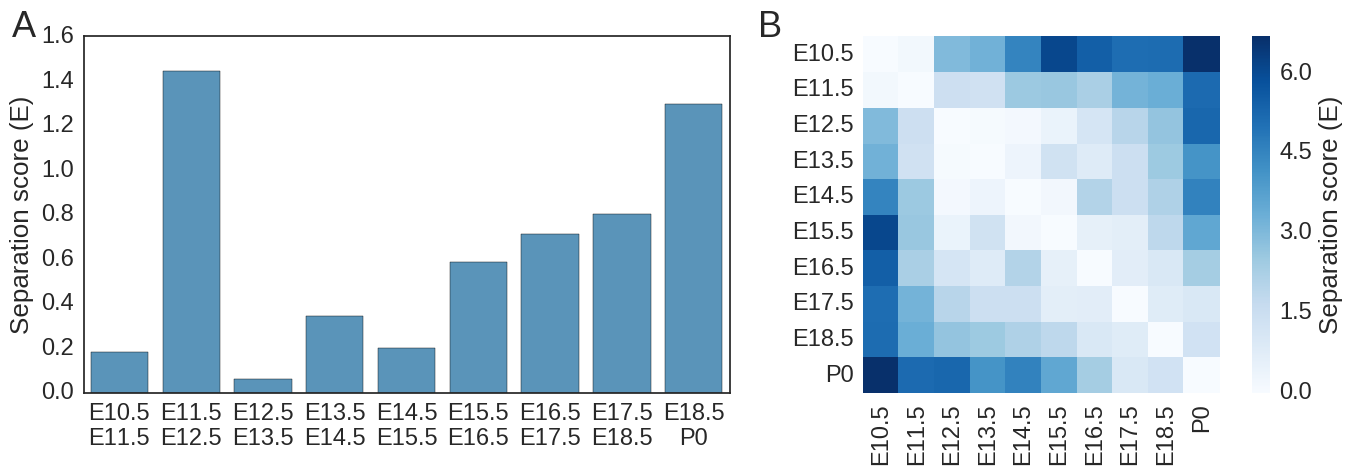

In [44]:
col_names = []
w = np.zeros((ncl*(ncl-1)/2, n))
e = np.zeros((ncl*(ncl-1)/2, n))
j = 0
for i in itertools.combinations(range(ncl),2):
    col_names += [t_points_bk[i[0]]+'-'+t_points_bk[i[1]]]
    X = np.concatenate((D['bkNSC_Ctpm'].values[:,(ynsc==i[0])], D['bkNSC_Ctpm'].values[:,(ynsc==i[1])]), axis=1)
    y = np.concatenate((np.zeros(np.sum(ynsc==i[0])), np.ones(np.sum(ynsc==i[1]))))
    s = suvrel(X, y, p=min_pvalue, print_gamma=True if j==0 else False)
    w[j,:] = s[0]
    e[j,:] = s[1]
    j += 1
    
suvrel_score  = pd.DataFrame(e.T, index=D['bkNSC_Ctpm'].index, columns=np.array(col_names))
metric_vector = pd.DataFrame(w.T, index=D['bkNSC_Ctpm'].index, columns=np.array(col_names))

matrix_score = np.zeros((ncl, ncl))
s = np.sum(w*e, axis=1)
j = 0
for i in itertools.combinations(range(ncl),2):
    matrix_score[i[0], i[1]] = s[j]
    matrix_score[i[1], i[0]] = s[j]
    j += 1
matrix_score = pd.DataFrame(matrix_score, index=np.array(t_points_bk), columns=np.array(t_points_bk))

f = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ax.text(-1.5, 1.6, 'A', fontsize=26)
ax.text(8.9, 1.6, 'B', fontsize=26)
sns.barplot([t_points_bk[i]+'\n'+t_points_bk[i+1] for i in range(ncl-1)],
            [matrix_score.values[i,i+1] for i in range(ncl-1)], color=cmap(0.6), ax=ax)
plt.ylabel('Separation score (E)')

ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
sns.heatmap(matrix_score, square=True,  cmap='Blues', ax=ax, cbar_kws={'label': 'Separation score (E)'})
#plt.savefig('./suvrel_output/figures/SeparationScore.pdf', format='pdf', dpi=200)

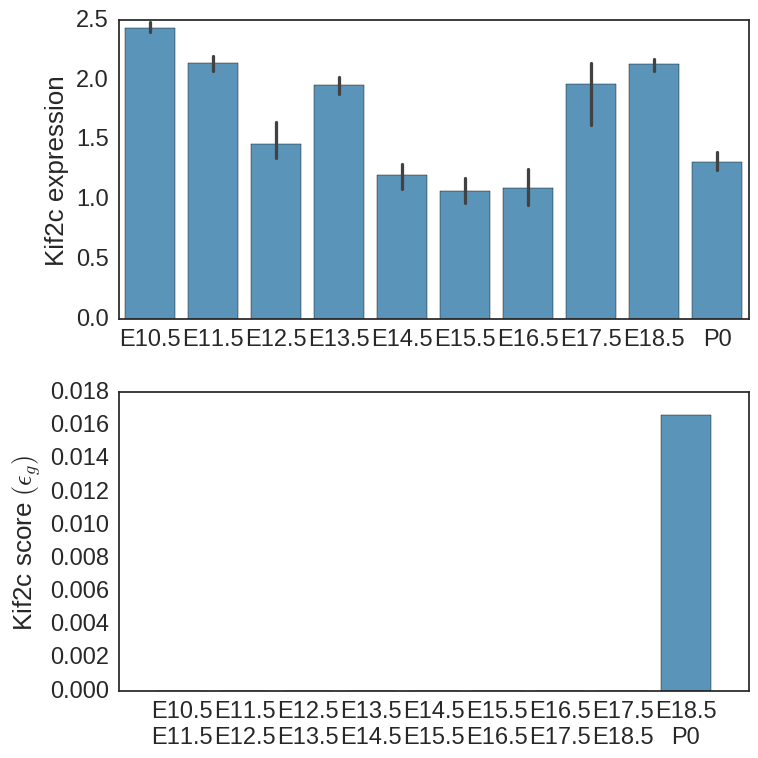

In [87]:
g_name = 'Kif2c'

f = plt.subplots(2, 1, figsize=(8, 8), tight_layout=True)
ax = plt.subplot2grid((2, 1), (0, 0), colspan=1, rowspan=1)
d = pd.concat([pd.DataFrame(D['bkNSC_Ctpm'].loc[id_to_ensembl([g_name])[0][0]]), 
               pd.DataFrame(ynsc, index=list_nsc.str.replace('-', '.').values, columns=['class'])], axis=1)
g = sns.factorplot(x='class', y=id_to_ensembl([g_name])[0][0], data=d, kind='bar', color=cmap(0.6), size=6, 
                   aspect=1.5, order=range(len(t_points_bk)), ax=ax)
plt.close(g.fig)
ax.set_ylabel(g_name+' expression')
plt.xlabel('')
ax.set_xticklabels(t_points_bk)

ax = plt.subplot2grid((2, 1), (1, 0), colspan=1, rowspan=1)
sns.barplot([t_points_bk[i]+'\n'+t_points_bk[i+1] for i in range(ncl-1)],
            [suvrel_score[t_points_bk[i]+'-'+t_points_bk[i+1]].loc[id_to_ensembl([g_name])[0][0]] for i in range(ncl-1)], 
            color=cmap(0.6), ax=ax)
ax.set_xlim(-1, 9)
ax.set_ylabel(g_name+' score '+r'$(\epsilon_g)$')
#plt.ylim([0,0.5])
plt.tight_layout()
plt.savefig('./suvrel_output/figures/'+g_name+'.pdf', format='pdf', dpi=200)

In [83]:
n_topgenes = 300

orig_stdout = sys.stdout
for i in range(ncl-1):
    t_comp = t_points_bk[i]+'-'+t_points_bk[i+1]
    f = open('suvrel_output/'+t_comp.replace('.','').replace('-','_')+'_top300.txt', 'w')
    sys.stdout = f

    l_topgenes = ensembl_to_id(D['bkNSC_Ctpm'].index[np.argsort(-metric_vector[t_comp].values)[:n_topgenes]])
    for g in range(n_topgenes):
         print l_topgenes[g]
        
    sys.stdout = orig_stdout
    f.close()
        
# l_topgenes = ensembl_to_id(D['bkNSC_Ctpm'].index[np.argsort(-np.sum(metric_vector.values, axis=1))[:n_topgenes]])
# for i in range(n_topgenes):
#      print l_topgenes[i]


KeyError: 'bkNSC_Ctpm'

In [34]:
n_topgenes = 300
t_comp = 'E11.5-E12.5'

l_topgenes = ensembl_to_id(D['bkNSC_Ctpm'].index[np.argsort(-metric_vector[t_comp].values)[:n_topgenes]])
for i in range(n_topgenes):
     print l_topgenes[i]
        
# l_topgenes = ensembl_to_id(D['bkNSC_Ctpm'].index[np.argsort(-np.sum(metric_vector.values, axis=1))[:n_topgenes]])
# for i in range(n_topgenes):
#      print l_topgenes[i]


Snord55
Scand1
Neurod6
Neurod2
Mir99a
Gm1673
Rpl9-ps7
Gm14303
Grcc10
Ccdc85b
Jund
Gm4149
Gm6180
Ier5l
Gm6044
Ppia
Dmrta2
Gm12196
Pcsk1n
CAAA01147332.1
Bhlhe22
Rpl29
Rprm
Hmgn2
Gm38158
RP23-433H22.3
Neurog2
Gm28266
Gm16288
Rps27-ps1
Syt4
Igfbp5
Gm12696
Nkx2-1
Mir6996
Mrps34
Gpr27
Gm6863
4930413G21Rik
Tpt1
Mir9-3
Gm13717
Tubb4b
Emx1
Rps7
Gm7964
Hist1h4b
Rpl17
Slc30a10
Rpl35a
Prr7
Gm45836
Tmem203
Sstr2
Serpini1
Hist1h2ae
C1qtnf4
Odc1
Znrf2
Gm22662
Gm45893
Rpl27
Lhx6
Eef1a1
Gm23077
Gm25262
Slc22a17
Zfp580
Gli1
Gadd45gip1
Sh3bp4
Rnaseh2c
Rlbp1
Pgp
Prdm8
Tmem178
Slc27a1
Bloc1s4
Zfp771
Irf2bp2
Snhg20
Zfp428
Cdkn1b
Gm5187
Fam181a
Gm3695
Slc25a5
Gm4335
Ppm1m
A930024E05Rik
Dpysl2
Prr18
Gm6767
Bok
Gm12099
Gm8186
Gm9619
Gm3671
Mir6387
Rasl11a
Sesn1
Pabpn1
Ybx1
Rpl7l1
Akt1s1
Gm18128
Rps15a
Arhgef25
Cabp1
Gm11438
Rbbp4
Eef1g
RP24-381P6.1
Hmgb1-ps7
Lrp2
Gm8319
Hnrnpc
Ppp1r35
Cnr1
Acat1
Arf1
Gm20689
Gm43758
Rps12-ps23
Gm15173
Gm44108
RP23-408N24.2
Gm29704
Gm37232
Gm8649
Fbxl15
Hmox1
Cox7c
Rhoa
Chrna4


[ 0.54184741  0.25789618  0.08196267]


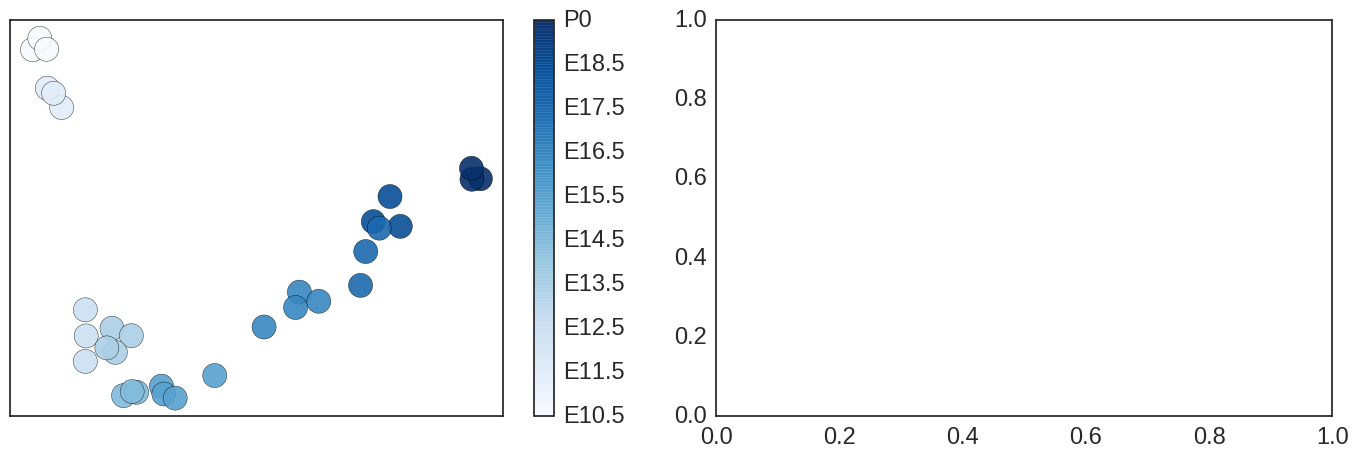

In [23]:
f = plt.subplots(1, 2, figsize=(14, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
ynsc = np.zeros(D['bkNSC_Ctpm'].shape[1])

for i in range(len(t_points_bk)):
    ynsc += i*1.0*(D['iSample_bk'].loc[list_nsc]['Time'] == t_points_bk[i]).values
    
x_fit = dimensional_reduction(D['bkNSC_Ctpm']*np.dot(np.sum(metric_vector.values, axis=1).reshape(n,1),np.ones((1,m)))
                              , c=ynsc, return_fit=True, ax=ax, ms=300, cticks=t_points_bk)
print x_fit.explained_variance_ratio_

# ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
# samples_sc = []
# ynsc_sc = []
# for i in range(len(t_points_sc)):
#     query = '(Condition == "WT") & (Cell_Type=="Hes5::GFP") & (Time=="'+t_points_sc[i]+'")'
#     samples_sc += list(D['iSample_sc'].query(query)['Sample_ID'].str.replace('-', '.'))
#     ynsc_sc += list(i*np.ones(len(D['iSample_sc'].query(query)['Sample_ID'])))

# D['scNSC'] = D['sc'][samples_sc]
# dimensional_reduction(D['scNSC'], c=ynsc_sc, x_fit=x_fit, ax=ax, ms=100)

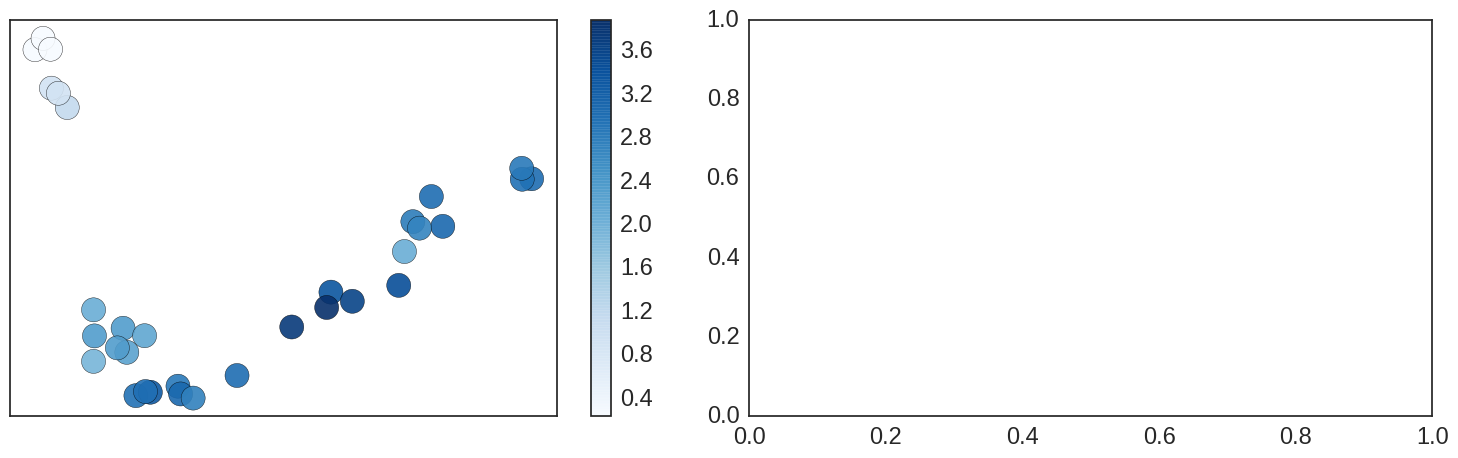

In [25]:
n   , m    = D['bkNSC_Ctpm'].shape
n_sc, m_sc = D['scNSC'].shape

g_name = 'Tcf4'
f = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)
ax = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
x_fit = dimensional_reduction(D['bkNSC_Ctpm']*np.dot(np.sum(metric_vector.values, axis=1).reshape(n,1),np.ones((1,m))),
                              c=D['bkNSC_Ctpm'].loc[id_to_ensembl([g_name])[0][0]], return_fit=True, ax=ax, ms=300)
# ax = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
# dimensional_reduction(D['scNSC']*np.dot(np.sum(metric_vector.values, axis=1).reshape(n_sc,1),np.ones((1,m_sc))),
#                       c=D['scNSC'].loc[id_to_ensembl([g_name])[0][0]], x_fit=x_fit, ax=ax, ms=150)